In [5]:
#initial imports
import pandas as pd
from pathlib import Path
import hvplot.pandas
import numpy as np
%matplotlib inline

In [6]:
#import seeds for TensorFlow
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [7]:
# Load the py-trends data for Bitcoin
pytrends_df = pd.read_csv('../resources/btc-pytrends.csv', index_col= "Day", infer_datetime_format=True, parse_dates=True)
pytrends_df = pytrends_df.rename(columns={'Bitcoin':'trends'})
pytrends_df

,trends
Day,
2021-10-04,40
2021-10-05,47
2021-10-06,59
2021-10-07,49
2021-10-08,45
...,...
2022-03-31,38
2022-04-01,37
2022-04-02,34


In [8]:
crypto_path = pd.read_csv('../resources/BTC-USD.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
bitcoin_df = crypto_path.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])
bitcoin_df = bitcoin_df.rename(columns={'Close':'close'})
bitcoin_df

,close
Date,
2021-10-04,49112.90234
2021-10-05,51514.81250
2021-10-06,55361.44922
2021-10-07,53805.98438
2021-10-08,53967.84766
...,...
2022-03-30,47062.66406
2022-03-31,45538.67578
2022-04-01,46281.64453


In [9]:
# Join the data into a single DataFrame
join_df = pytrends_df.join(bitcoin_df, how="inner")
join_df

,trends,close
2021-10-04,40,49112.90234
2021-10-05,47,51514.81250
2021-10-06,59,55361.44922
2021-10-07,49,53805.98438
2021-10-08,45,53967.84766
...,...,...
2022-03-30,38,47062.66406
2022-03-31,38,45538.67578
2022-04-01,37,46281.64453
2022-04-02,34,45868.94922


In [10]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'GoogleTrends' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(join_df, window_size, feature_column, target_column)

In [12]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with training feature data X_train
scaler.fit(X_train)

# Scale features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit MinMaxScaler object with training target data y_train
scaler.fit(y_train)

# Scale target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [14]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining LSTM RNN model
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [17]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [18]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [19]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
119/119 [==============================] - 8s 17ms/step - loss: 0.1756
Epoch 2/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0950
Epoch 3/10
119/119 [==============================] - 2s 15ms/step - loss: 0.0977
Epoch 4/10
119/119 [==============================] - 2s 17ms/step - loss: 0.0983
Epoch 5/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0980
Epoch 6/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0974
Epoch 7/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0968
Epoch 8/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0961
Epoch 9/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0955
Epoch 10/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0950


In [20]:
# Evaluate the model
model.evaluate(X_test, y_test)

2/2 [==============================] - 2s 44ms/step - loss: 0.0147


0.014656614512205124

In [21]:
# Make some predictions
predicted = model.predict(X_test)

In [22]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [23]:
# Create a DataFrame of Real and Predicted values
price_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
price_df

,Real,Predicted
2022-02-11,43565.11328,44293.656250
2022-02-12,42407.93750,44293.046875
2022-02-13,42244.46875,44294.304688
2022-02-14,42197.51563,44305.253906
2022-02-15,42586.91797,44323.468750
2022-02-16,44575.20313,44335.242188
2022-02-17,43961.85938,44336.566406
2022-02-18,40538.01172,44352.714844
2022-02-19,40030.97656,44342.265625
2022-02-20,40122.15625,44329.839844


<AxesSubplot:>

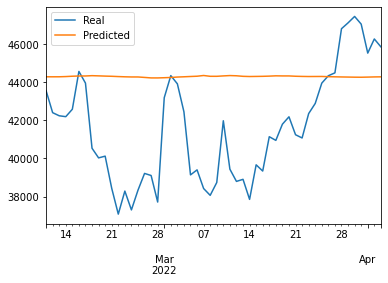

In [24]:
# Plot the real vs predicted values as a line chart
price_df.plot()